<a href="https://colab.research.google.com/gist/agneselombardi/4d1ebc4c2d6a752e13bd92fe4eb424df/machinelearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data exploration**

In [1]:
#Import libraries and datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
nltk.download ('punkt')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#connect the drive
from google.colab import drive
drive.mount('/content/drive')

#import the dataframe 
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/OLIDv1.0.zip', 'r')
zip_ref.extractall('tmp')
zip_ref.close()
df = pd.read_csv('tmp/olid-training-v1.0.tsv', sep = '\t')
df


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH
13238,27429,@USER Pussy,OFF,UNT,NaN


In [3]:
#Remove the ID column and the subtask b and c
df = df.drop(columns = ['id', 'subtask_b', 'subtask_c'], axis= 1)

In [4]:
#verify that the data set is balanced
df.groupby('subtask_a').count()

,tweet
subtask_a,
NOT,8840
OFF,4400


The dataset is imbalanced

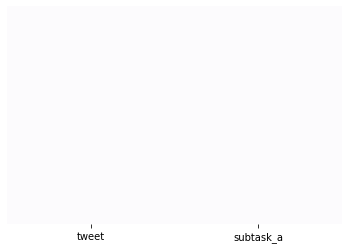

In [5]:
#verify if the dataset have empty values
import seaborn as sns
sns.heatmap(df.isnull(), yticklabels = False, cbar= False, cmap = "Purples")

No empty values are displayed

In [6]:
#find out the length of the twitts
print('Avarage word lenght of tweets is {0:.0f}.'.format(np.mean(df['tweet'].apply(lambda x:len(x.split())))))

print('Max word lenght of tweets is {0:.0f}.'.format(np.max(df['tweet'].apply(lambda x:len(x.split())))))

Avarage word lenght of tweets is 22.
Max word lenght of tweets is 103.


Text(0.5, 1.0, 'Distribution of Tweet length')

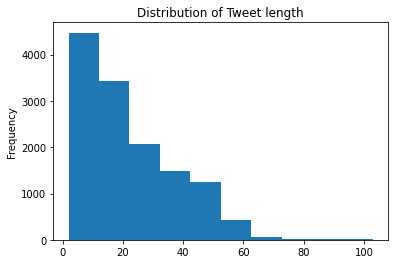

In [7]:
#visualize the length of tweets with matplot
df['tweet'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.title('Distribution of Tweet length')

(-0.5, 399.5, 199.5, -0.5)

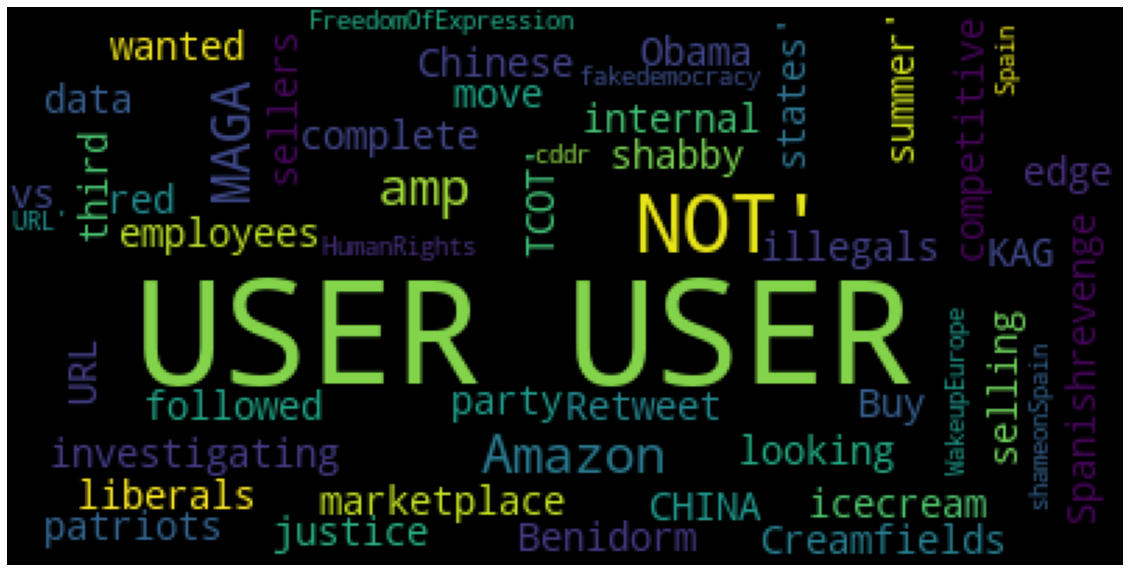

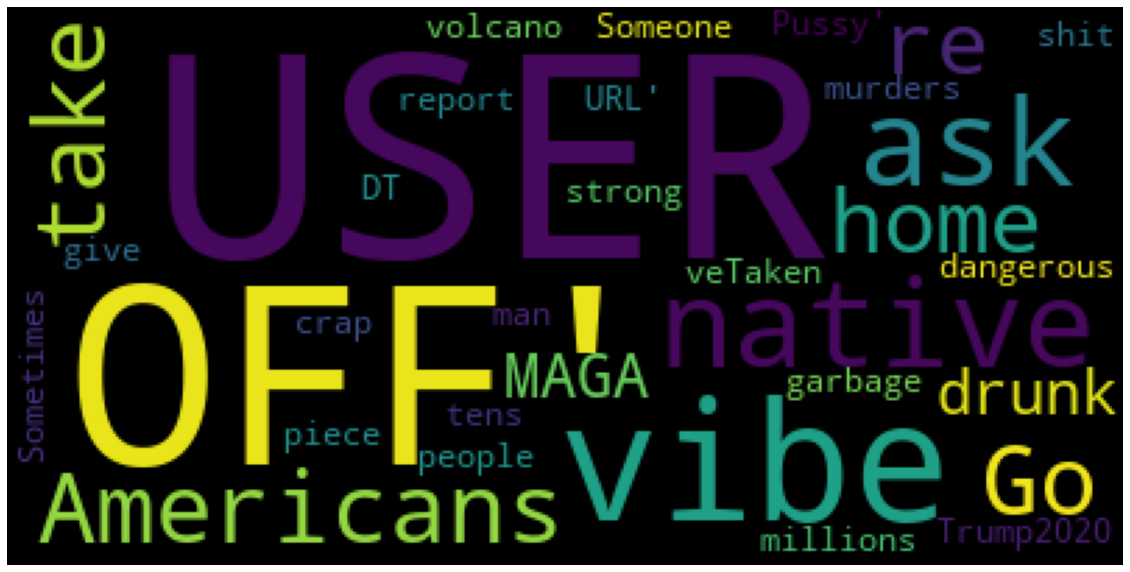

In [8]:
#wordcloud for offensive and not offensive tweet
from wordcloud import WordCloud
from os import path

positive = df[(df['subtask_a'] == 'NOT')].values
negative = df[(df['subtask_a'] == 'OFF')].values

plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(str(positive)))
plt.axis("off")

plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(str(negative)))
plt.axis("off")

**Data cleaning**


In [9]:
#lowercase
df["tweet"] = df["tweet"].str.lower()

In [10]:
#remove punctuation with the regular expression
df["tweet"] = df["tweet"].str.replace('[^\w\s]','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [11]:
#remove stop words
stop = stopwords.words('english')

def stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop])

df["tweet"] = df["tweet"].apply(stopwords)

In [12]:
#I don't want to apply stemming and lemmatisation

In [13]:
#converting emojis to plain text
!pip install emot
from emot.emo_unicode import UNICODE_EMOJI

def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
        return text

df["tweet"] = df["tweet"].apply(convert_emojis)

In [14]:
#spelling correction
from textblob import TextBlob
df['tweet'][:10].apply(lambda x: str(TextBlob(x).correct()))  #in this case I applied the function to the first 10 raws, but it should be applied to the                   
                                                              #total number of raws in the dataframe (13240)

0                       user ask native americans take
1    user user go home your drunk user magna trump2...
2    amazon investigation chinese employees selling...
3        user someone shouldvetaken piece shit volcano
4    user user drama wanted liberals amp illegal mo...
5                                   user liberals koko
6                         user user oh does tough shit
7    user literally talking ll mass shooting like s...
8                                    user buy icecream
9    user canada doesn need another luck already en...
Name: tweet, dtype: object

In [23]:
#remove url
def remove_urls(text):
    url_pattern = re.compile(r'((www\.[\s]+)|(https?://[^\s]+))')
    return url_pattern.sub(r'', text)

#Replace #word with word
def remove_hash(text):
  hash_pattern = re.compile(r'#([^\s]+)')
  return hash_pattern.sub(r'\1', text)

#remove user
def remove_user(text):
 user_pattern = re.compile(r'\buser\b')
 return user_pattern.sub(r'', text)

#remove numbers and dates
def remove_num(text):
  num_pattern = re.compile(r'[0-9]{8}[\/,:][0-9]{2}[\/,:][0-9]{2,4}')
  return num_pattern.sub(r'', text)

df['tweet'] = df['tweet'].apply(remove_urls)
df["tweet"] = df["tweet"].apply(remove_hash)
df["tweet"] = df["tweet"].apply(remove_user)
df["tweet"] = df["tweet"].apply(remove_num)

In [16]:
#remove HTML tags
from bs4 import BeautifulSoup

def html(text):
    return BeautifulSoup(text, "lxml").text

df['tweet'] = df['tweet'].apply(html)

In [17]:
#tokenization and #vectorization

df["tweet"].apply(word_tokenize)
vectorizer = CountVectorizer()
tweet_text = df["tweet"]
final_text = vectorizer.fit_transform(tweet_text)

print(vectorizer.get_feature_names_out())
print(final_text.toarray())

['00000' '005' '01' ... '𝓭𝔂𝓼𝓹𝓱𝓸𝓻𝓲𝓪' '𝙼𝚌𝙿𝙾𝚄𝚃𝚂𝙵𝚊𝚌𝚎' '𝙿𝚎𝚝𝚊𝚕𝚜']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [24]:
#create group of training and test
x = final_text
y = df["subtask_a"]

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

**Training a Naive Bayes model**

In [19]:
from sklearn.naive_bayes import  MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

In [20]:
y_pred = classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1475  266]
 [ 447  460]]
              precision    recall  f1-score   support

         NOT       0.77      0.85      0.81      1741
         OFF       0.63      0.51      0.56       907

    accuracy                           0.73      2648
   macro avg       0.70      0.68      0.68      2648
weighted avg       0.72      0.73      0.72      2648

